In [1]:
# Group Assignment Multivariate Econometrics Fall 2020

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

In [3]:
#plt.style.use('/home/luuk/Documents/MNRAS_Style.mplstyle')

In [4]:
# Read in the Excel file with the data
df = pd.read_excel('./MVE_assignment_2020_dataset.xlsx')
countries = ['Netherlands','Norway']
# Select from df only those for our countries
df = df[df['cntry.name'].apply(lambda x: x in countries)]
# Drop columns that are irrelevant (ISO names of countries)
df = df.drop(['ISO_N3','ISO_C3'],axis=1)
# Set index to increase readability
df.columns = ['Country','Year','Precipitation','Radiation','Average Temp','GDP','GDP per Capita','Population','Land','CPI']
df = df.set_index(['Country','Year'])
# Replace '..' with nans to avoid problems
df = df.replace('..',np.nan)

In [5]:
# Available data:
# Mean precipitation
# Mean radiation
# Average yearly temperaure
# GDP
# GDP per capita
# Population, total
# Agricultural land
# Crop production index

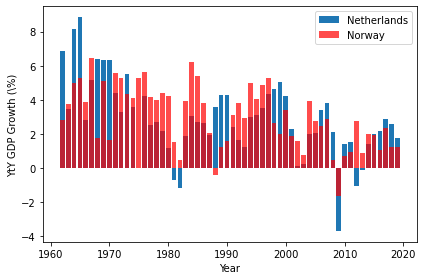

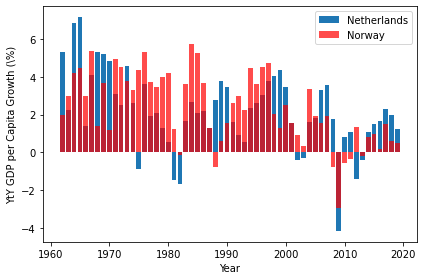

In [6]:
class simple_figures():
    def __init__(self):
        self.df = df
    
    def GPD_Growth(self):
        fig, ax = plt.subplots()
        GDP_Growth = df['GDP'].unstack().T.pct_change()*100
        ax.bar(GDP_Growth.index,GDP_Growth.Netherlands,label='Netherlands',alpha=1)
        ax.bar(GDP_Growth.index,GDP_Growth.Norway, label='Norway',alpha=0.7,color='red')

        ax.set_xlabel('Year')
        ax.set_ylabel('YtY GDP Growth (\%)')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
    def GPDpC_Growth(self):
        fig, ax = plt.subplots()
        GDP_Growth = df['GDP per Capita'].unstack().T.pct_change()*100
        ax.bar(GDP_Growth.index,GDP_Growth.Netherlands,label='Netherlands',alpha=1)
        ax.bar(GDP_Growth.index,GDP_Growth.Norway, label='Norway',alpha=0.7, color='red')

        ax.set_xlabel('Year')
        ax.set_ylabel('YtY GDP per Capita Growth (\%)')
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        
        
figs = simple_figures()
figs.GPD_Growth()
figs.GPDpC_Growth()

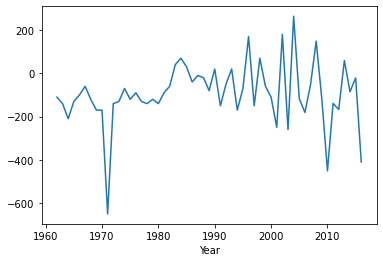

In [7]:
class preprocessing():
    def __init__(self):
        self.demean()
        self.stationary(df)
        self.detrend()
        return
        
    def demean(self):
        """Group by country and subtract mean of each column
           from the data. This will enhance the visibility of 
           outliers"""
        self.demeaned = df  - df.groupby('Country').mean()
        
    def loglevels(self):
        """Simply take the logarithm of all levels"""
        self.log = np.log(df)
        
    def stationary(self,df):
        """To detrend the data we check for each timeseries
           if it is stationary or not. This function returns 
           for each country and column the p value for the ADF
           test"""
        stationary_results = pd.DataFrame()
        for country in countries:
            # loop through countries
            subdf = df.loc[country]
            for col in subdf.columns:
                # Run ADF test to check for stationarity
                ADF_p = adfuller(subdf[col].dropna())[1]
                stationary_results.loc[country,col] = ADF_p
        self.stationary_results = stationary_results
        # Low p values are stationary
        self.isstationary = stationary_results<0.05
        
    def detrend(self):
        """If it is not stationary we should take the difference 
           sequence. If time series is stationary, we can keep the
           original"""
        # The non-stationary timeseries are detrended by taking diff series
        not_stationary = ['Average Temp','GDP','GDP per Capita',
                          'Population','Land','CPI']
        self.detrended = df.copy()
        for col in not_stationary:
            self.detrended[col+'_detrended'] = df[col].unstack().T.diff().T.stack()
        return

preprocessed = preprocessing()
#preprocessed.isstationary
#preprocessed.detrended['GDP_detrended'].values
preprocessed.detrended.loc['Netherlands'].Land_detrended.plot()

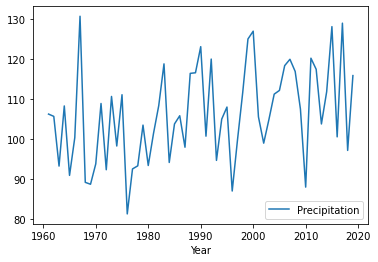

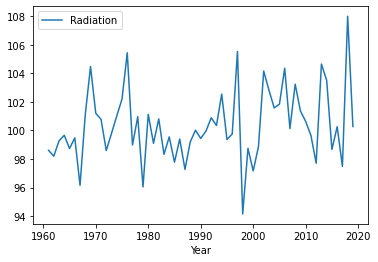

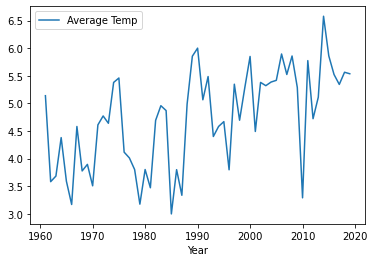

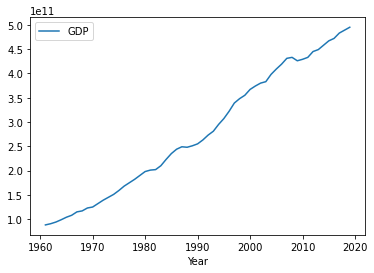

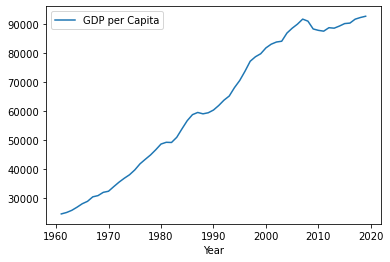

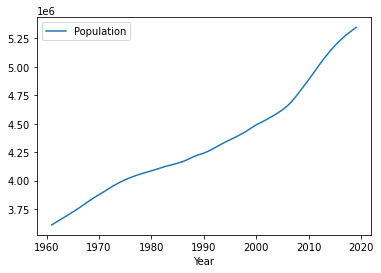

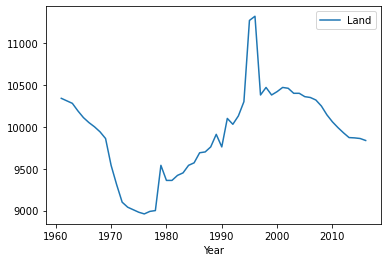

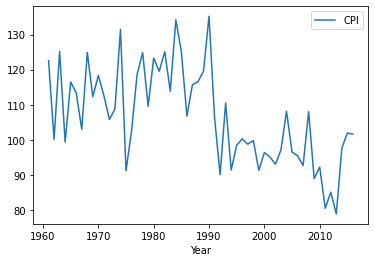

In [8]:
# Preprocessing
df.loc['Norway'].reset_index().plot(x='Year',y='Precipitation')
df.loc['Norway'].reset_index().plot(x='Year',y='Radiation')
df.loc['Norway'].reset_index().plot(x='Year',y='Average Temp')
df.loc['Norway'].reset_index().plot(x='Year',y='GDP')
df.loc['Norway'].reset_index().plot(x='Year',y='GDP per Capita')
df.loc['Norway'].reset_index().plot(x='Year',y='Population')
df.loc['Norway'].reset_index().plot(x='Year',y='Land')
df.loc['Norway'].reset_index().plot(x='Year',y='CPI')

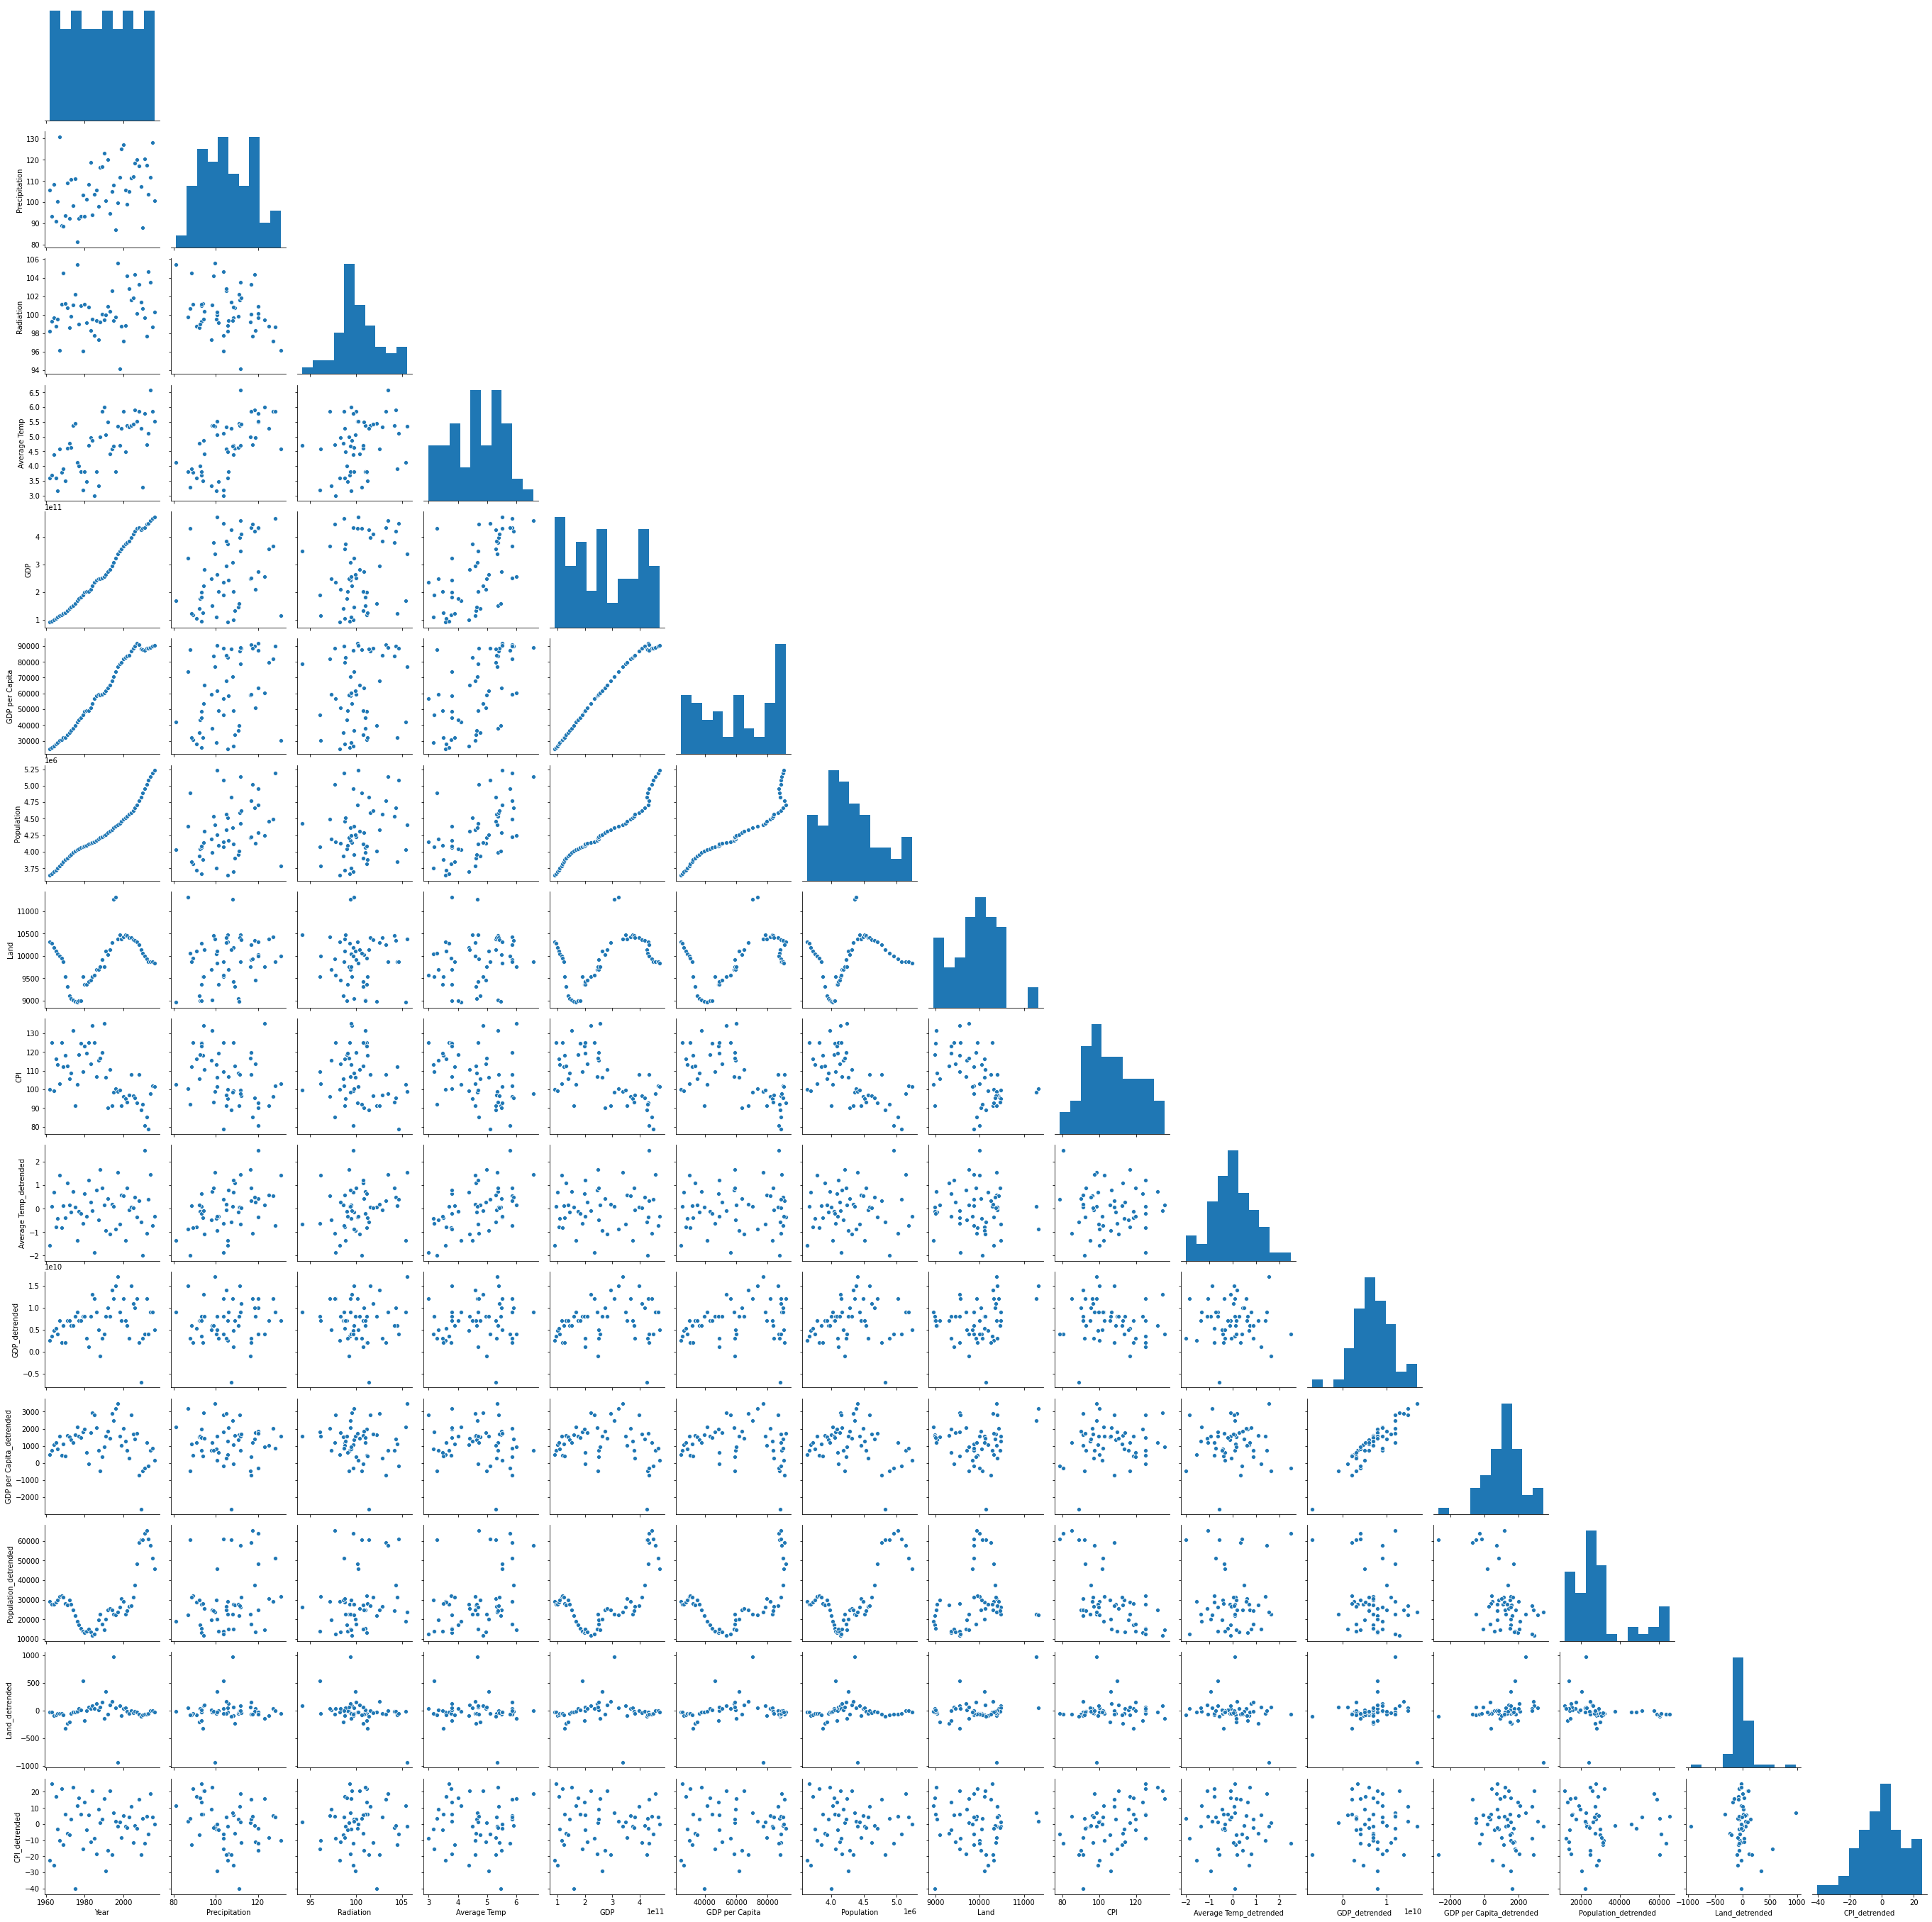

In [9]:
sns.pairplot(preprocessed.detrended.loc['Norway'].reset_index().dropna(),corner=True)
plt.show()

<h3>Analysis of the order of integration</h3>

In [22]:
# As before, we first apply a simple DF test to identify stationarity
stationary_results = pd.DataFrame()
for country in countries:
    # loop through countries
    subdf = df.loc[country]
    for col in subdf.columns:
        # Run ADF test to check for stationarity
        ADF_p = adfuller(subdf[col].dropna())[1]
        stationary_results.loc[country,col] = ADF_p
stationary_results = stationary_results
# Low p values are stationary
isstationary = stationary_results<0.05
isstationary = isstationary.T
isstationary

,Netherlands,Norway
Precipitation,True,True
Radiation,True,True
Average Temp,True,False
GDP,False,False
GDP per Capita,False,False
Population,False,False
Land,False,False
CPI,False,False


In [ ]:
# Order of integration: 
# which difference series make the series stationary?

Time series processes whose $d^{th}$ difference have a stationary, invertible ARMA(p,q) representation are called integrated processes of order $d$, $I(d)$. The corresponding representation

$$\alpha (L) \Delta^d x_t = \mu + \theta(L) \epsilon_t$$

This representation is called the ARIMA(p,d,q) model

In [ ]:
# Thus for each non stationary series we test order 1,2 and 3 difference sequence

In [14]:
def delta_operator(x):
    return np.diff(x)
x = np.arange(0,10,1)

In [39]:
integratability = pd.DataFrame()
for country in countries:
    # loop through countries
    subdf = df.loc[country]
    for col in subdf.columns:
        timeseries = subdf[col].dropna()
        # Run ADF test to check for stationarity
        ADF_p = adfuller(timeseries)[1]
        integratability = integratability.append({'Country': country, 
                                                      'OoI': 0, 
                                                      'Series':col,
                                                      'pval': ADF_p}, ignore_index=True)
        for OoI in [1,2,3]:
            timeseries = delta_operator(timeseries)
            ADF_p = adfuller(timeseries)[1]
            integratability = integratability.append({'Country': country, 
                                                      'OoI': OoI, 
                                                      'Series':col,
                                                      'pval': ADF_p}, ignore_index=True)
integratability.set_index(['Country','OoI','Series']).unstack()

pval                                             \
Series           Average Temp           CPI           GDP GDP per Capita   
Country     OoI                                                            
Netherlands 0.0  4.295539e-03  7.548517e-01  9.654216e-01   8.643122e-01   
            1.0  7.825679e-08  6.450223e-10  5.098304e-05   3.455341e-05   
            2.0  1.405950e-06  1.419825e-14  2.305206e-13   4.763445e-13   
            3.0  1.594725e-05  5.887687e-05  1.729727e-04   4.682111e-05   
Norway      0.0  5.014007e-01  3.550474e-01  9.804486e-01   6.414697e-01   
            1.0  2.050589e-08  1.219702e-08  6.734121e-05   1.536160e-03   
            2.0  5.876094e-07  4.250493e-06  4.499118e-05   6.033231e-09   
            3.0  1.665483e-07  2.375896e-03  4.250687e-05   3.107110e-06   

                                                                         
Series                   Land    Population Precipitation     Radiation  
Country     OoI                                                          
Netherlands 0.0  4.860772e-01  6.061072e-01  2.484276e-08  7.112066e-06  
            1.0  5.280226e-10  4.932314e-02  5.587173e-08  1.884346e-06  
            2.0  6.603753e-04  3.955756e-04  2.504864e-08  1.491992e-06  
            3.0  1.163521e-04  2.154375e-07  1.445196e-08  8.621160e-06  
Norway      0.0  4.502631e-01  9.988543e-01  6.886737e-10  4.038752e-11  
            1.0  5.289472e-07  8.124866e-01  6.693651e-07  1.675284e-10  
            2.0  1.711575e-08  1.598413e-02  9.490837e-05  5.571370e-06  
            3.0  2.010057e-09  1.367121e-02  1.680348e-06  2.644286e-08